### TO DO:
- LC and Controls Data interpolate Missing power data :D -> turned out that missing power data was RECOVERY data, and that end_exercise wasn't properly adjusted
- Integrate correction in code -> integrated all corrections in either preprocessing, or the processing function as a separate function that can be turned on or off at leisure
- See if Data before SOM makes sense
- Solve the SOM map issue -> Apparently the linspace had to be set to the highest power, it was power based, and now I got a good heat map. However, this part does not affect the Movement deviation profile
- Take care of movement deviation profile
- See if Data After SOM creation makes sense

In [86]:
import os
import sys
import numpy as np

# get the current working directory
cwd = os.getcwd()
# append the \SOM_package directory to the system path
sys.path.append(cwd + '\SOM_package')
from som_make import som_make
from som_bmus import som_bmus
from som_ind2sub import som_ind2sub
from som_denormalize import som_denormalize
import matplotlib.pyplot as plts
from Functions import *


In [87]:
data_paths = ['ME.data', 'LC.data', 'Controls.data']
length_prime = 0
exercise_df = {}
for data_p in data_paths:
    data_name = data_p.split('.')[0]
    exercise_df[data_name] = process_data(data_p)
    length = determine_longest_trial(exercise_df[data_name])
    if length > length_prime:
        length_prime = length
length_prime = length_prime + 1

for key in exercise_df.keys():
    exercise_df[key].loc[exercise_df[key]['t'] > 6, 't'] = np.nan
    sData_exercise, sData_exercise_copy, sData_exercise_norm, compnames = Create_som(exercise_df[key], length_prime)
    if key == 'ME':
        sData_ME = sData_exercise.copy()
        sData_ME_copy = sData_exercise_copy.copy()
        sData_ME_norm = sData_exercise_norm.copy()
        sData_ME_norm_copy = copy.deepcopy(sData_ME_norm)
        plotdata_ME = sData_ME['data'].copy()
    elif key == 'LC':
        sData_LC = sData_exercise.copy()
        sData_LC_copy = sData_exercise_copy.copy()
        sData_LC_norm = sData_exercise_norm.copy()
        sData_LC_norm_copy = copy.deepcopy(sData_LC_norm)
        plotdata_LC = sData_LC['data'].copy()
    elif key == 'Controls':
        sData_controls = sData_exercise.copy()
        sData_controls_copy = sData_exercise_copy.copy()
        sData_controls_norm = sData_exercise_norm.copy()
        sData_controls_norm_copy = copy.deepcopy(sData_controls_norm)
        plotdata_controls = sData_controls['data'].copy()  
    else:
        print('Error in data reading: Weird data path')

Determining map size...
 sTopol first round done
Map size [35, 15]
Initialization...
 sTopol first round done
Training using batch algorithm...
Rough training phase...
Training: 0 / 0 s

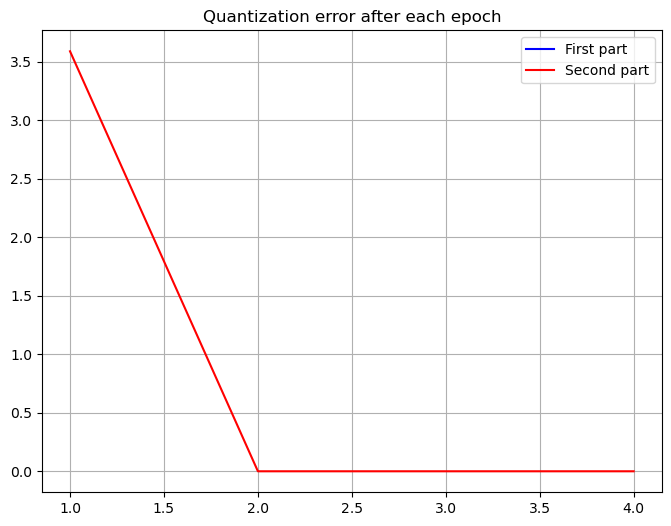

Training: 0 / 1 s

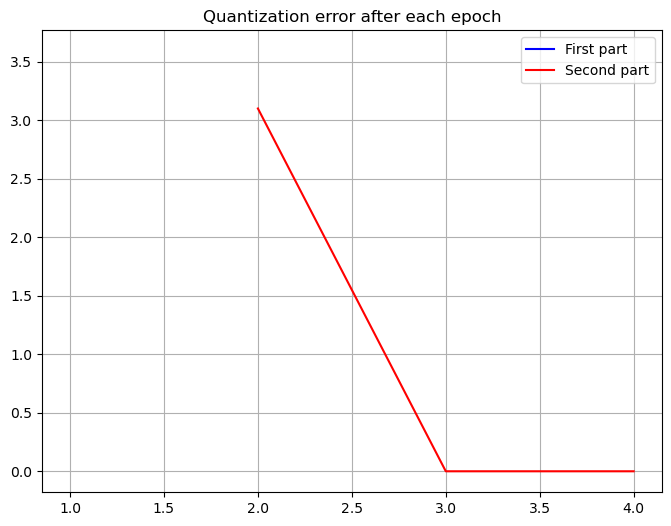

Training: 1 / 1 s

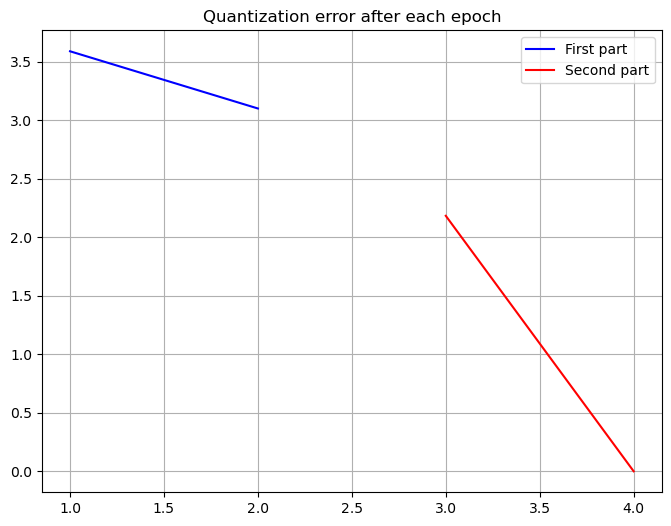

Training: 1 / 1 s

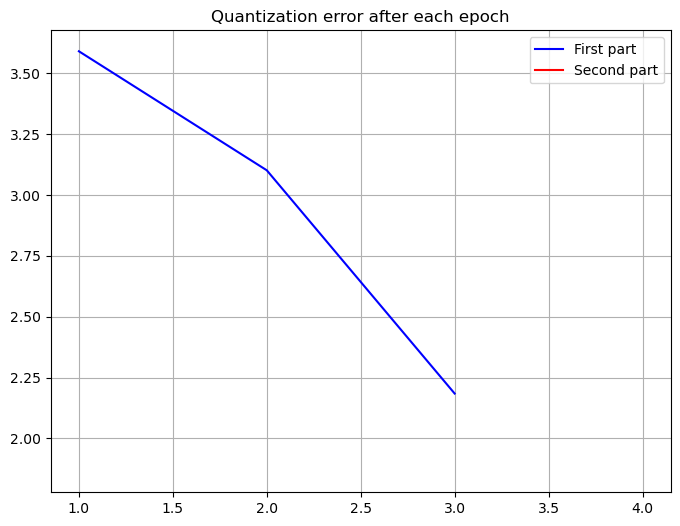



finetuning phase...
Training: 0 / 0 s

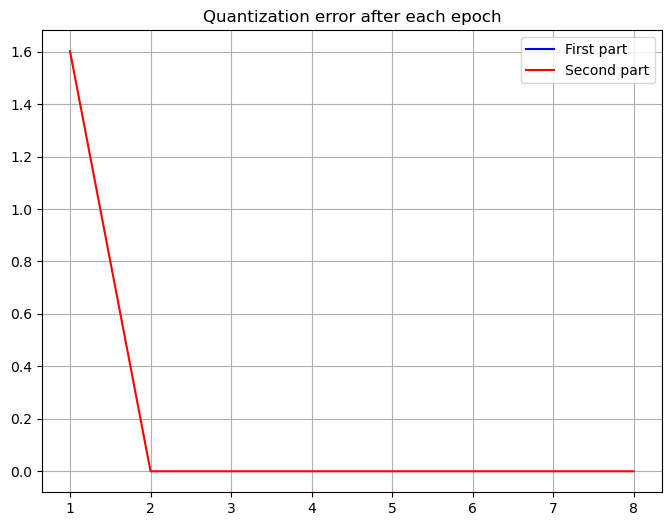

Training: 0 / 2 s

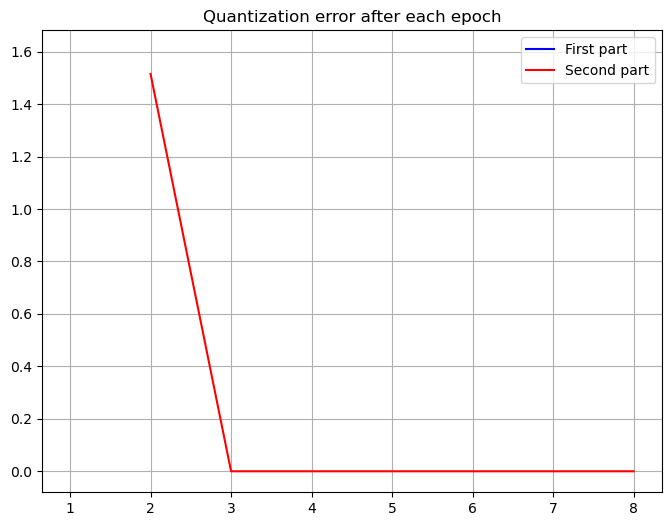

Training: 1 / 2 s

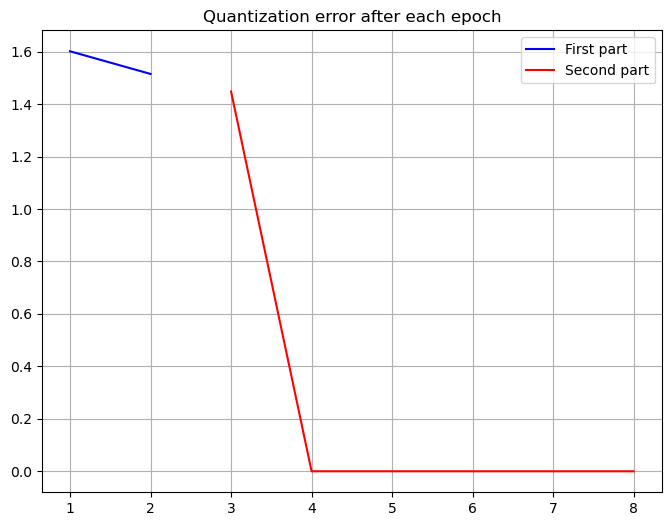

Training: 1 / 2 s

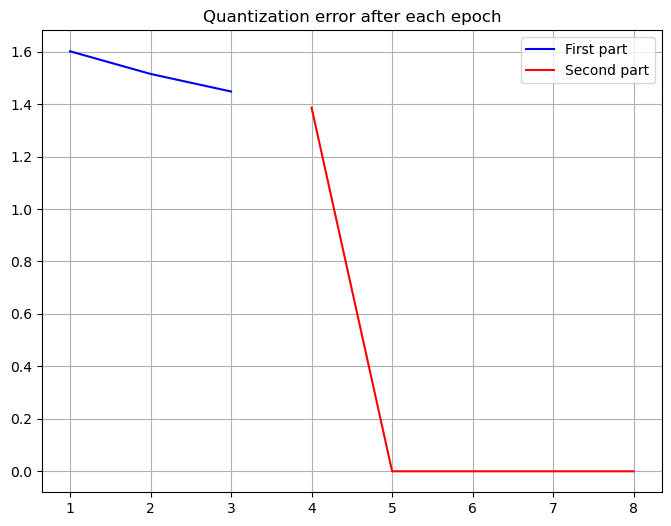

Training: 1 / 2 s

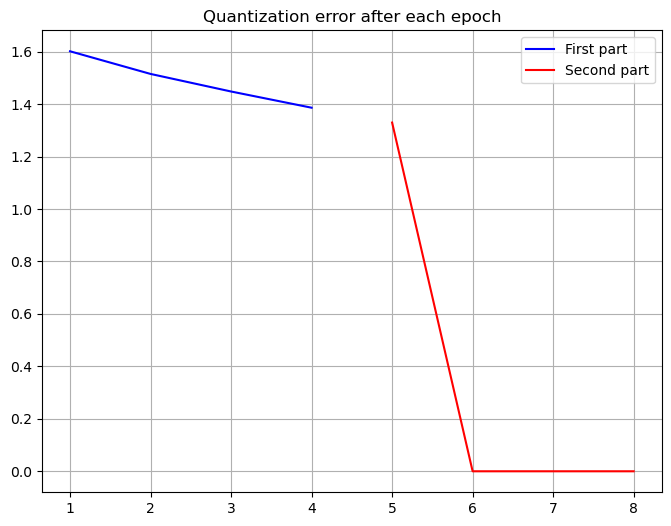

Training: 2 / 2 s

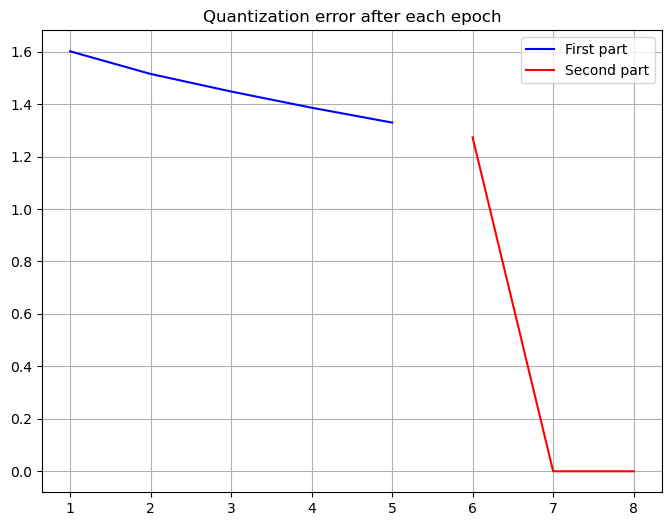

Training: 2 / 3 s

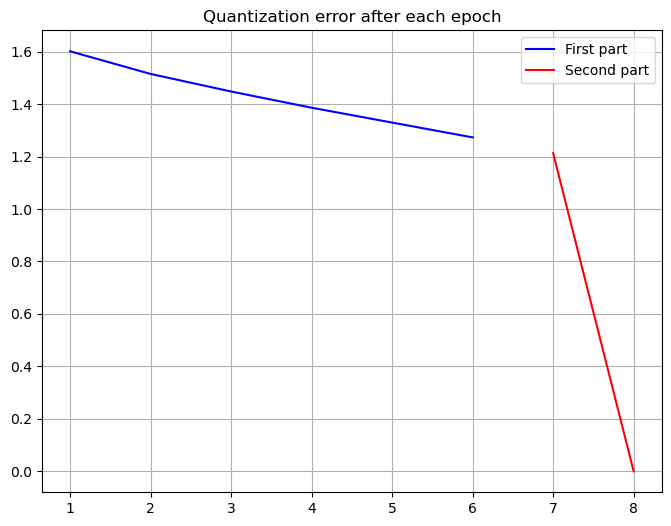

Training: 3 / 3 s

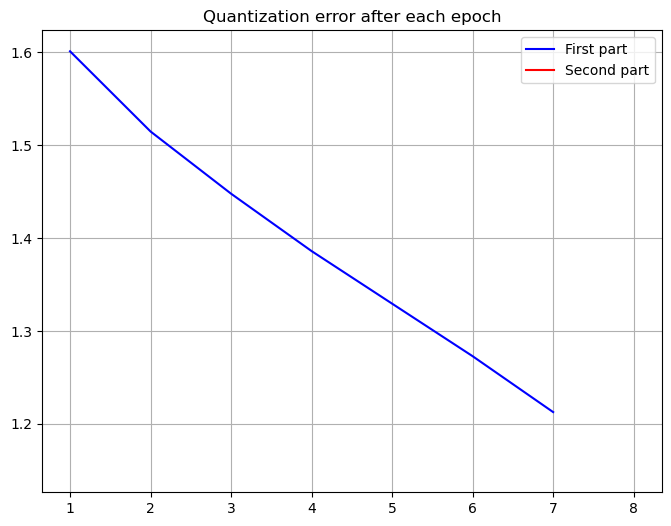



Final quantization error: 0.630
Final topographic error:  0.444


In [88]:
sMap = som_make(sData_controls_norm, *['lattice', 'shape', 'training', 'mapsize'],**{'lattice':'hexa', 'shape':'sheet', 'training': 'long','mapsize':'large'})

In [89]:
#find the best matching unit for each data point
Traj_train, Qerrs_train = som_bmus(sMap, sData_controls_norm, 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:,[0]]), axis=1)
line1 = np.concatenate((sMap['topol']['msize'], [0]))

Traj_LC, Qerrs_LC = som_bmus(sMap, sData_LC_norm_copy, 'all')
Traj_LC_coord = som_ind2sub(sMap, Traj_LC[:,0])
Traj_LC_coord = np.concatenate((Traj_LC_coord, Qerrs_LC[:,[0]]), axis=1)

Traj_ME, Qerrs_ME = som_bmus(sMap, sData_ME_norm_copy, 'all')
Traj_ME_coord = som_ind2sub(sMap, Traj_ME[:,0])
Traj_ME_coord = np.concatenate((Traj_ME_coord, Qerrs_ME[:,[0]]), axis=1)

In [90]:
# denormalize the weight vectors
M = som_denormalize(sMap['codebook'].copy(), *[sMap])

Traj_train, Qerrs_train = som_bmus(M, plotdata_controls.copy(), 'all')
Traj_train_coord = som_ind2sub(sMap, Traj_train[:,0])
Traj_train_coord = np.concatenate((Traj_train_coord, Qerrs_train[:,[0]]), axis=1)

Traj_LC, Qerrs_LC = som_bmus(M, plotdata_LC.copy(), 'all')
Traj_LC_coord = som_ind2sub(sMap, Traj_LC[:,0])
Traj_LC_coord = np.concatenate((Traj_LC_coord, Qerrs_LC[:,[0]]), axis=1)

Traj_ME, Qerrs_ME = som_bmus(M, plotdata_ME.copy(), 'all')
Traj_ME_coord = som_ind2sub(sMap, Traj_ME[:,0])
Traj_ME_coord = np.concatenate((Traj_ME_coord, Qerrs_ME[:,[0]]), axis=1)

breakpoint()


c:\Users\User\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\User\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


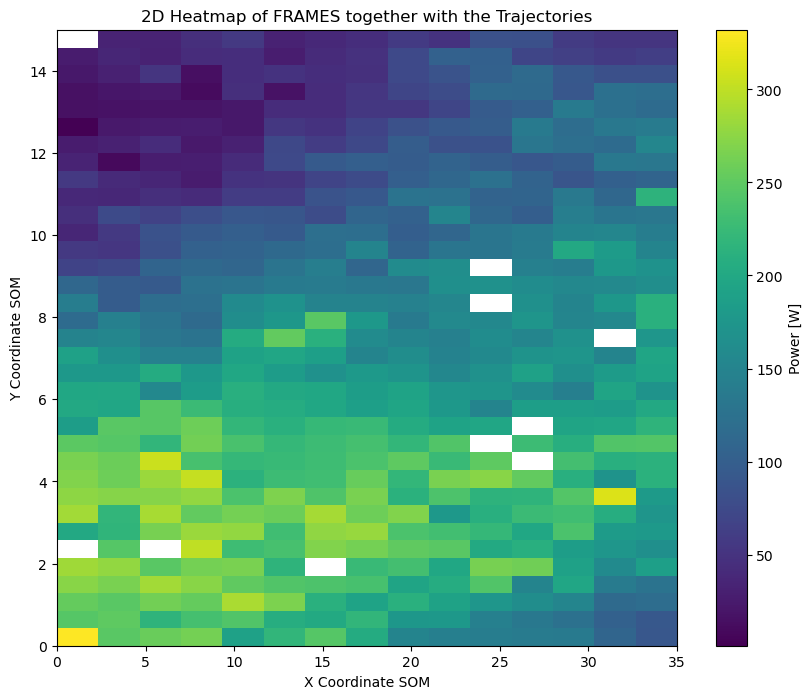

In [91]:
integer_division = []
for i in range(3,150):
    if len(plotdata_controls) % i == 0:
        integer_division.append(i)
integer_division[-1]

index = [[None for _ in range(line1[1])] for _ in range(line1[0])]
# Iterate over t and q using nested loops
for t in range(0, line1[1]):
    for q in range(0, line1[0]):
        # Calculate the index
        index[q][t] = np.where((Traj_train_coord[:,0] == q) & (Traj_train_coord[:,1] == t))[0]

# compute average Frame number per neuron
# Flatten index using list comprehension
index_reQE = [item for sublist in index for item in sublist]
# Number of frames (t)
num_repeats = len(plotdata_controls) // integer_division[-2]

## Create a linearly spaced vector from 1 to 101
frame = np.linspace(1, 434,434)
FRAMES = np.tile(frame, (num_repeats, 1)).flatten()
FRAMES = FRAMES.reshape(-1, 1)

FRAMES_SOM1 = np.zeros((len(M), 1))
for r in range(len(M)):
    FRAMES_SOM1[r, 0] = np.mean(FRAMES[index_reQE[r]])

FRAMES_re = FRAMES_SOM1.reshape(line1[0], line1[1])

extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.figure(figsize=(10, 8))
plt.imshow(FRAMES_re, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Power [W]')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of FRAMES together with the Trajectories')
breakpoint()




In [92]:

integer_division = {}
for x, plotdata in zip(['Controls', 'LC', 'ME'], [plotdata_controls, plotdata_LC, plotdata_ME]):
        # Create a list to store the values
        integer_division[x] = []
        # iterate over the range 3 to 101
        for i in range(3, 435):
            # Check if the length of the data is divisible by i
            if len(plotdata) % i == 0:
                # If it is, store the value in the dictionary
                integer_division[x].append(i)

MEAN_train range: X(0.0 to 31.0), Y(0.0 to 9.0)
MEAN_LC range: X(0.0 to 32.0), Y(0.0 to 7.0)
MEAN_ME range: X(0.0 to 32.0), Y(0.0 to 6.0)
FRAMES_re_normalized shape: (35, 15)
FRAMES_re shape: (35, 15)


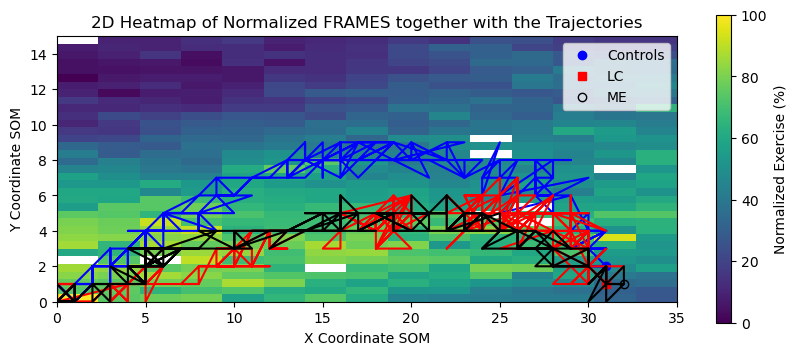

In [93]:
## EXPLORE THE MAP
x_train = np.reshape(Traj_train_coord[:, 0], (integer_division['Controls'][-1], -1), order='F')
y_train = np.reshape(Traj_train_coord[:, 1], (integer_division['Controls'][-1], -1), order='F') 
MEAN_train = np.column_stack((np.round(np.mean(x_train, axis=1)), np.round(np.mean(y_train, axis=1))))
STD_train = np.column_stack((np.round(np.std(x_train, axis=1)), np.round(np.std(y_train, axis=1))))

x_LC = np.reshape(Traj_LC_coord[:, 0], (integer_division['LC'][-1], -1), order='F')
y_LC = np.reshape(Traj_LC_coord[:, 1], (integer_division['LC'][-1], -1), order='F')
MEAN_LC = np.column_stack((np.round(np.mean(x_LC, axis=1)), np.round(np.mean(y_LC, axis=1))))
STD_LC = np.column_stack((np.round(np.std(x_LC, axis=1)), np.round(np.std(y_LC, axis=1))))

x_ME = np.reshape(Traj_ME_coord[:, 0], (integer_division['ME'][-1], -1), order='F')
y_ME = np.reshape(Traj_ME_coord[:, 1], (integer_division['ME'][-1], -1), order='F')
MEAN_ME = np.column_stack((np.round(np.mean(x_ME, axis=1)), np.round(np.mean(y_ME, axis=1))))
STD_ME = np.column_stack((np.round(np.std(x_ME, axis=1)), np.round(np.std(y_ME, axis=1))))

marker_sizes = np.ones(min(integer_division['Controls'][-1], integer_division['LC'][-1])) * 5  # Initialize all markers to size 5
marker_sizes[0] = 7  # Make the first marker larger

print(f"MEAN_train range: X({MEAN_train[:, 0].min()} to {MEAN_train[:, 0].max()}), Y({MEAN_train[:, 1].min()} to {MEAN_train[:, 1].max()})")
print(f"MEAN_LC range: X({MEAN_LC[:, 0].min()} to {MEAN_LC[:, 0].max()}), Y({MEAN_LC[:, 1].min()} to {MEAN_LC[:, 1].max()})")
# Normalize the FRAMES_re array to a range of 0 to 100
FRAMES_re_normalized = (FRAMES_re - np.nanmin(FRAMES_re)) / (np.nanmax(FRAMES_re) - np.nanmin(FRAMES_re)) * 100

print(f"MEAN_ME range: X({MEAN_ME[:, 0].min()} to {MEAN_ME[:, 0].max()}), Y({MEAN_ME[:, 1].min()} to {MEAN_ME[:, 1].max()})")
print(f"FRAMES_re_normalized shape: {FRAMES_re_normalized.shape}")
extent = [0, FRAMES_re_normalized.shape[0], 0, FRAMES_re_normalized.shape[1]]

plt.figure(figsize=(10, 4)) 
plt.imshow(FRAMES_re_normalized, aspect='auto', cmap='viridis', origin='lower', extent=extent)
plt.colorbar(label='Normalized Exercise (%)')
plt.xlabel('X Coordinate SOM')
plt.ylabel('Y Coordinate SOM')
plt.title('2D Heatmap of Normalized FRAMES together with the Trajectories')
print(f"FRAMES_re shape: {FRAMES_re.shape}")
extent = [0, FRAMES_re.shape[0], 0, FRAMES_re.shape[1]]

plt.plot(MEAN_train[0, 0], MEAN_train[0, 1], 'bo', label='Controls')
plt.plot(MEAN_LC[0, 0], MEAN_LC[0, 1], 'rs', label='LC')
plt.plot(MEAN_ME[0, 0], MEAN_ME[0, 1], 'ko', label='ME', markerfacecolor='none')

plt.plot(MEAN_train[:, 0], MEAN_train[:, 1], 'b-', markersize=4)
plt.plot(MEAN_LC[:, 0], MEAN_LC[:, 1], 'r-', markersize=4)
plt.plot(MEAN_ME[:, 0], MEAN_ME[:, 1], 'k-', markersize=4)

plt.gca().set_aspect('equal', adjustable='box')

plt.legend()
plt.show()
breakpoint()


In [94]:
integer_division.keys()

dict_keys(['Controls', 'LC', 'ME'])

In [95]:
for i in integer_division.keys():
    print(integer_division[i])

[4, 7, 13, 14, 26, 28, 31, 52, 62, 91, 124, 182, 217, 364, 403, 434]
[4, 5, 7, 10, 14, 20, 28, 31, 35, 62, 70, 124, 140, 155, 217, 310, 434]
[4, 7, 13, 14, 26, 28, 31, 52, 62, 91, 124, 182, 217, 364, 403, 434]


In [96]:
x =np.linspace(1,100, integer_division['Controls'][-1])

In [97]:
np.arange(1, 100, integer_division['Controls'][-1] + 1)

array([1])

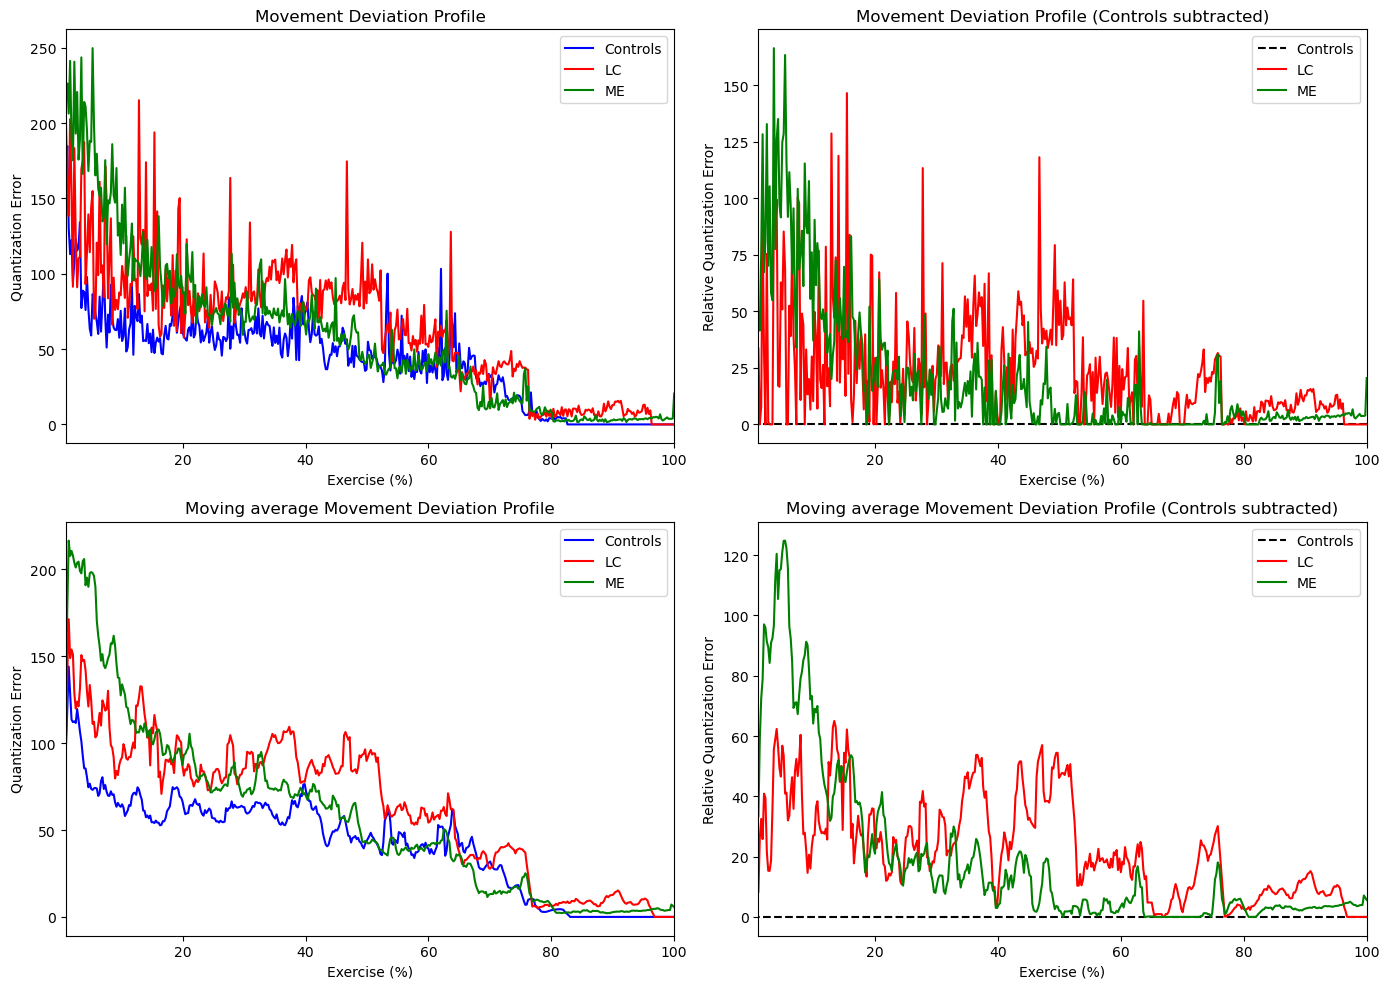

In [98]:
## MOVEMENT DEVIATION PROFILE
# here the aim is to find the difference in Quantization Errors of the train and the test set
# relative to the SOM. These errors are then compared and illustrated into the so-called Movement 
# Deviation Profile (MDP)

# Reshape the first column of Traj_train
error_train = np.reshape(Traj_train_coord[:, 2], (integer_division['Controls'][-1], -1), order='F')
MEAN_error_train = np.mean(error_train, axis=1)
STD_error_train = np.std(error_train, axis=1)

error_LC = np.reshape(Traj_LC_coord[:, 2], (integer_division['LC'][-1], -1), order='F')
MEAN_error_LC = np.mean(error_LC, axis=1)
STD_error_LC = np.std(error_LC, axis=1)

error_ME = np.reshape(Traj_ME_coord[:, 2], (integer_division['ME'][-1], -1), order='F')
MEAN_error_ME = np.mean(error_ME, axis=1)
STD_error_ME = np.std(error_ME, axis=1)

# Plot all 3 standard 
x = np.linspace(1, 100, integer_division['Controls'][-1])
y = STD_error_train

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# First subplot
axs[0, 0].plot(x, MEAN_error_train, 'b', label='Controls')
axs[0, 0].plot(x, MEAN_error_LC, 'r', label='LC')
axs[0, 0].plot(x, MEAN_error_ME, 'g', label='ME')
axs[0, 0].set_xlim([1, 100])
axs[0, 0].set_xlabel('Exercise (%)')
axs[0, 0].set_ylabel('Quantization Error')
axs[0, 0].set_title('Movement Deviation Profile')
axs[0, 0].legend()

# Second subplot
normalized_lc = MEAN_error_LC - MEAN_error_train
normalized_me = MEAN_error_ME - MEAN_error_train
normalized_me_smaller_is_zero = normalized_me.copy()
normalized_me_smaller_is_zero[normalized_me < 0] = 0
normalized_lc_smaller_is_zero = normalized_lc.copy()
normalized_lc_smaller_is_zero[normalized_lc < 0] = 0
normalized_me[normalized_me < 0]
axs[0, 1].hlines(0, 0, 100, 'k', '--', label='Controls')
axs[0, 1].plot(x, normalized_lc_smaller_is_zero, 'r', label='LC')
axs[0, 1].plot(x, normalized_me_smaller_is_zero, 'g', label='ME')
axs[0, 1].set_xlim([1, 100])
axs[0, 1].set_xlabel('Exercise (%)')
axs[0, 1].set_ylabel('Relative Quantization Error')
axs[0, 1].set_title('Movement Deviation Profile (Controls subtracted)')
axs[0, 1].legend()

# Third subplot
window_size = 5
controls_ma = np.convolve(MEAN_error_train, np.ones(window_size) / window_size, mode='same')
lc_ma = np.convolve(MEAN_error_LC, np.ones(window_size) / window_size, mode='same')
me_ma = np.convolve(MEAN_error_ME, np.ones(window_size) / window_size, mode='same')
axs[1, 0].plot(x, controls_ma, 'b', label='Controls')
axs[1, 0].plot(x, lc_ma, 'r', label='LC')
axs[1, 0].plot(x, me_ma, 'g', label='ME')
axs[1, 0].set_xlim([1, 100])
axs[1, 0].set_xlabel('Exercise (%)')
axs[1, 0].set_ylabel('Quantization Error')
axs[1, 0].set_title('Moving average Movement Deviation Profile')
axs[1, 0].legend()

# Fourth subplot
normalized_lc_ma = np.convolve(normalized_lc_smaller_is_zero, np.ones(window_size) / window_size, mode='same')
normalized_me_ma = np.convolve(normalized_me_smaller_is_zero, np.ones(window_size) / window_size, mode='same')
axs[1, 1].hlines(0, 0, 100, 'k', '--', label='Controls')
axs[1, 1].plot(x, normalized_lc_ma, 'r', label='LC')
axs[1, 1].plot(x, normalized_me_ma, 'g', label='ME')
axs[1, 1].set_xlim([1, 100])
axs[1, 1].set_xlabel('Exercise (%)')
axs[1, 1].set_ylabel('Relative Quantization Error')
axs[1, 1].set_title('Moving average Movement Deviation Profile (Controls subtracted)')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


In [102]:
# statistical analysis of the Movement Deviation Profile
# The aim is to determine the statistical significance of the differences in the Movement Deviation Profile
# between the LC and ME groups. This is done by checking for normality and then performing a t-test
# on the data.
# if the data is not normally distributed, a non-parametric test is performed.

# Check for normality
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
# check for normality
# verbose

# Shapiro-Wilk test for normality
for group, data in zip(['Controls', 'LC', 'ME'], [MEAN_error_train, MEAN_error_LC, MEAN_error_ME]):
    stat, p = shapiro(data)
    print(f'\n{group} - Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{group} - Sample looks Gaussian (fail to reject H0)')
    else:
        print(f'{group} - Sample does not look Gaussian (reject H0)')

print('\n')
# mann-whitney U test
# compare samples
stat, p = mannwhitneyu(MEAN_error_train, MEAN_error_ME)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
print('Comparing Controls and ME')
if p > alpha:
    print(f'not significant (fail to reject H0)')
else:
    print(f'significant (reject H0)')

rbcorr_controls_ME = 1 - ((2 * stat) / (len(MEAN_error_train) * len(MEAN_error_ME))) 
print(f'Rank-biserial correlation between Controls and ME: {rbcorr_controls_ME}')

print('\n')
stat, p = mannwhitneyu(MEAN_error_train, MEAN_error_LC)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
print('Comparing Controls and LC')
if p > alpha:
    print(f'not significant (fail to reject H0)')
else:
    print(f'significant (reject H0)')

rbcorr_controls_LC = 1 - ((2 * stat) / (len(MEAN_error_train) * len(MEAN_error_LC)))
print(f'Rank-biserial correlation between Controls and LC: {rbcorr_controls_LC}')

print('\n')
stat, p = mannwhitneyu(MEAN_error_LC, MEAN_error_ME)
print('Statistics=%.3f, p=%.4f' % (stat, p))
# interpret
print('Comparing LC and ME')
if p > alpha:
    print(f'not significant (fail to reject H0)')
else:
    print(f'significant (reject H0)')

rbcorr_LC_ME = 1 - ((2 * stat) / (len(MEAN_error_LC) * len(MEAN_error_ME)))
print(f'Rank-biserial correlation between LC and ME: {rbcorr_LC_ME}')


# perform statistical tests on the first 50% of the data
# Check for normality


print('\n')
# mann-whitney U test
# compare samples
half_sample = int(np.floor(MEAN_error_train.shape[0]*0.5))
stat, p = mannwhitneyu(MEAN_error_train[:half_sample], MEAN_error_ME[:half_sample])
print('Statistics=%.3f, p=%.3f' % (stat, p))
rbcorr_controls_LC_05 = 1 - ((2 * stat) / (len(MEAN_error_train[:half_sample]) * len(MEAN_error_ME[:half_sample])))
print(f'Rank-biserial correlation between Controls and ME: {rbcorr_controls_LC_05}')

print('\n')

stat, p = mannwhitneyu(MEAN_error_train[:half_sample], MEAN_error_LC[:half_sample])
print('Statistics=%.3f, p=%.3f' % (stat, p))
rbcorr_controls_LC_05 = 1 - ((2 * stat) / (len(MEAN_error_train[:half_sample]) * len(MEAN_error_LC[:half_sample])))
print(f'Rank-biserial correlation between Controls and LC: {rbcorr_controls_LC_05}')

print('\n')

stat, p = mannwhitneyu(MEAN_error_LC[:half_sample], MEAN_error_ME[:half_sample])
print('Statistics=%.3f, p=%.4f' % (stat, p))
rbcorr_LC_ME_05 = 1 - ((2 * stat) / (len(MEAN_error_LC[:half_sample]) * len(MEAN_error_ME[:half_sample])))
print(f'Rank-biserial correlation between LC and ME: {rbcorr_LC_ME_05}')



Controls - Statistics=0.926, p=0.000
Controls - Sample does not look Gaussian (reject H0)

LC - Statistics=0.945, p=0.000
LC - Sample does not look Gaussian (reject H0)

ME - Statistics=0.883, p=0.000
ME - Sample does not look Gaussian (reject H0)


Statistics=77403.000, p=0.000
Comparing Controls and ME
significant (reject H0)
Rank-biserial correlation between Controls and ME: 0.17812015545031745


Statistics=62240.500, p=0.000
Comparing Controls and LC
significant (reject H0)
Rank-biserial correlation between Controls and LC: 0.339118477776126


Statistics=106964.000, p=0.0005
Comparing LC and ME
significant (reject H0)
Rank-biserial correlation between LC and ME: -0.13576419121238503


Statistics=9287.000, p=0.000
Rank-biserial correlation between Controls and ME: 0.6055554375756547


Statistics=5000.000, p=0.000
Rank-biserial correlation between Controls and LC: 0.7876361783006647


Statistics=27178.000, p=0.0054
Rank-biserial correlation between LC and ME: -0.15432478922890702


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


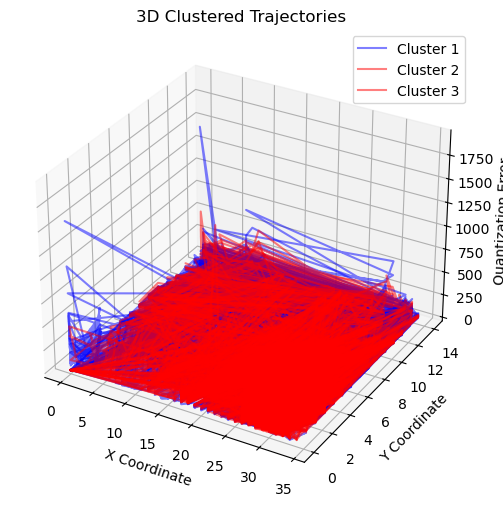

In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans


### CLUSTER the data based on the bmus
data_cl_controls = np.reshape(Traj_train_coord[:,0:3],(26, 434,3))
data_cl_LC = np.reshape(Traj_LC_coord[:,0:3],(10, 434,3))
data_cl_ME = np.reshape(Traj_ME_coord[:,0:3],(26, 434, 3))

# Combine data along the first axis (vertical concatenation)
combined_data = np.concatenate((data_cl_controls, data_cl_LC, data_cl_ME), axis=0)

# Reshape data for clustering
flattened_data = combined_data.reshape(combined_data.shape[0], -1)

# Initialize K-means model
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit K-means model to flattened data
kmeans.fit(flattened_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Separate indices of data1 and data2
num_data_controls = data_cl_controls.shape[0]
num_data_LC = data_cl_LC.shape[0]
num_data_ME = data_cl_ME.shape[0]


# Create arrays to store indices of data1 and data2 in each cluster
data_controls_clusters = np.zeros(num_data_controls, dtype=int)  # Array to store cluster labels for Controls
data_LC_clusters = np.zeros(num_data_LC, dtype=int)  # Array to store cluster labels for LC
data_ME_clusters = np.zeros(num_data_ME, dtype=int) # Array to store cluster labels for ME



# Assign cluster labels to data1
data_controls_clusters[cluster_labels[:num_data_controls] == 0] = 1  # Assign cluster 1 to trajectories in data1
data_controls_clusters[cluster_labels[:num_data_controls] == 1] = 2  # Assign cluster 2 to trajectories in data1
data_controls_clusters[cluster_labels[:num_data_controls] == 2] = 3


# Assign cluster labels to data2
data_LC_clusters[cluster_labels[num_data_controls:num_data_controls+num_data_LC] == 0] = 1 # Assign cluster 1 to trajectories in data_LC
data_LC_clusters[cluster_labels[num_data_controls:num_data_controls+num_data_LC] == 1] = 2 # Assign cluster 2 to trajectories in data_LC
data_LC_clusters[cluster_labels[num_data_controls:num_data_controls+num_data_LC] == 2] = 3 # Assign cluster 3 to trajectories in data_LC

data_ME_clusters[cluster_labels[num_data_controls+num_data_LC:] == 0] = 1 # Assign cluster 1 to trajectories in data_ME
data_ME_clusters[cluster_labels[num_data_controls+num_data_LC] == 1] = 2 # Assign cluster 2 to trajectories in data_ME
data_ME_clusters[cluster_labels[num_data_controls+num_data_LC] == 2] = 3 # Assign cluster 3 to trajectories in data_ME


# Combine the cluster labels into a single array
cluster_assignment = np.concatenate((data_controls_clusters, data_LC_clusters, data_ME_clusters))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot data1 trajectories
for i in range(num_data_controls):
    if cluster_assignment[i] == 1:
        ax.plot(data_cl_controls[i, :, 0], data_cl_controls[i, :, 1], data_cl_controls[i, :, 2], color='blue', alpha=0.5, label='Cluster 1' if i == 0 else '')
    elif cluster_assignment[i] == 2:
        ax.plot(data_cl_controls[i, :, 0], data_cl_controls[i, :, 1], data_cl_controls[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')
    elif cluster_assignment[i] == 3:
        ax.plot(data_cl_controls[i, :, 0], data_cl_controls[i, :, 1], data_cl_controls[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

# Plot data2 trajectories
for i in range(num_data_LC):
    index = i + num_data_controls
    if cluster_assignment[index] == 1:
        ax.plot(data_cl_LC[i, :, 0], data_cl_LC[i, :, 1], data_cl_LC[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')
    elif cluster_assignment[index] == 2:
        ax.plot(data_cl_LC[i, :, 0], data_cl_LC[i, :, 1], data_cl_LC[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')
    elif cluster_assignment[index] == 3:
        ax.plot(data_cl_LC[i, :, 0], data_cl_LC[i, :, 1], data_cl_LC[i, :, 2], color='red', alpha=0.5, label='Cluster 2' if i == 0 else '')

for i in range(num_data_ME):
    index = i + num_data_controls +num_data_LC
    if cluster_assignment[index] == 1:
        ax.plot(data_cl_ME[i, :, 0], data_cl_ME[i, :, 1], data_cl_ME[i, :, 2], color='red', alpha=0.5, label='Cluster 3' if i == 0 else '')
    elif cluster_assignment[index] == 2:
        ax.plot(data_cl_ME[i, :, 0], data_cl_ME[i, :, 1], data_cl_ME[i, :, 2], color='red', alpha=0.5, label='Cluster 3' if i == 0 else '')
    elif cluster_assignment[index] == 3:
        ax.plot(data_cl_ME[i, :, 0], data_cl_ME[i, :, 1], data_cl_ME[i, :, 2], color='red', alpha=0.5, label='Cluster 3' if i == 0 else '')

plt.title('3D Clustered Trajectories')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Quantization Error')
plt.legend()
plt.grid(True)
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())
plt.show()


In [105]:
Controlsss = cluster_assignment[0:26]
LCsss = cluster_assignment[26:36]
MEsss = cluster_assignment[36:62]

aprsss = [Controlsss, LCsss, MEsss]
aprsss

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 2, 2, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1])]

In [ ]:

# Print the cluster assignments (just for demonstration)
print("Cluster assignments:")
for i in range(len(cluster_assignment)):
    if i < num_data_controls:
        print(f"Data_controls slice {i} is in Cluster {cluster_assignment[i]}")
    elif i < num_data_controls + num_data_LC:
        print(f"Data_LC slice {i - num_data_controls} is in Cluster {cluster_assignment[i]}")


Cluster assignments:
Data_controls slice 0 is in Cluster 1
Data_controls slice 1 is in Cluster 1
Data_controls slice 2 is in Cluster 1
Data_controls slice 3 is in Cluster 1
Data_controls slice 4 is in Cluster 1
Data_controls slice 5 is in Cluster 1
Data_controls slice 6 is in Cluster 1
Data_controls slice 7 is in Cluster 1
Data_controls slice 8 is in Cluster 1
Data_controls slice 9 is in Cluster 1
Data_controls slice 10 is in Cluster 1
Data_controls slice 11 is in Cluster 1
Data_controls slice 12 is in Cluster 1
Data_controls slice 13 is in Cluster 1
Data_controls slice 14 is in Cluster 1
Data_controls slice 15 is in Cluster 1
Data_controls slice 16 is in Cluster 1
Data_controls slice 17 is in Cluster 1
Data_controls slice 18 is in Cluster 1
Data_controls slice 19 is in Cluster 1
Data_controls slice 20 is in Cluster 2
Data_controls slice 21 is in Cluster 1
Data_controls slice 22 is in Cluster 1
Data_controls slice 23 is in Cluster 1
Data_controls slice 24 is in Cluster 1
Data_controls 

In [ ]:
def participant_average(sData,col):
    df_data = pd.DataFrame(sData['data'])
    df_data.columns = compnames
    df_labels = pd.DataFrame(sData['labels'])
    df_labels.columns = sData['label_names']
    group_constant = 434
    df = pd.concat([df_data, df_labels], axis=1)
    strt = df.groupby('Participant').head(1).index.tolist()
    strt_l2 = []
    for i in range(strt[1]):
        strt_l1 = []
        for j in range(0,len(strt)):
            if i == 0:
                strt_l1.append(group_constant*j)
            else:
                strt_l1.append(i+(group_constant*j))
        strt_l2.append(strt_l1)
    average_col = []
    nan_count = []
    for i in range (len(strt_l2)):
        average_col.append(df.loc[strt_l2[i], col].mean())
        nan_count.append(df.loc[strt_l2[i], col].count().sum()/len(strt)*100)
    return average_col,nan_count

def plot_group_averages(col, sData_ME = sData_ME, sData_controls = sData_controls, sData_LC = sData_LC):
    ME_avg, nan_me = participant_average(sData_ME, col)
    Controls_avg, nan_con = participant_average(sData_controls, col)
    LC_avg, nan_lc = participant_average(sData_LC, col)
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

    # Plot averages in the first subplot
    ax1.plot(ME_avg, label='ME')
    ax1.plot(Controls_avg, label='Controls')
    ax1.plot(LC_avg, label='LC')
    ax1.legend()
    ax1.set_title(col)

    # Plot NaN counts in the second subplot
    ax2.plot(nan_me, label='ME NaN')
    ax2.plot(nan_con, label='Controls NaN')
    ax2.plot(nan_lc, label='LC NaN')
    ax2.legend()
    ax2.set_ylabel('% participants left')
    ax2.set_title('NaN Counts')
    
    # Display the plots
    plt.tight_layout()
    plt.show()


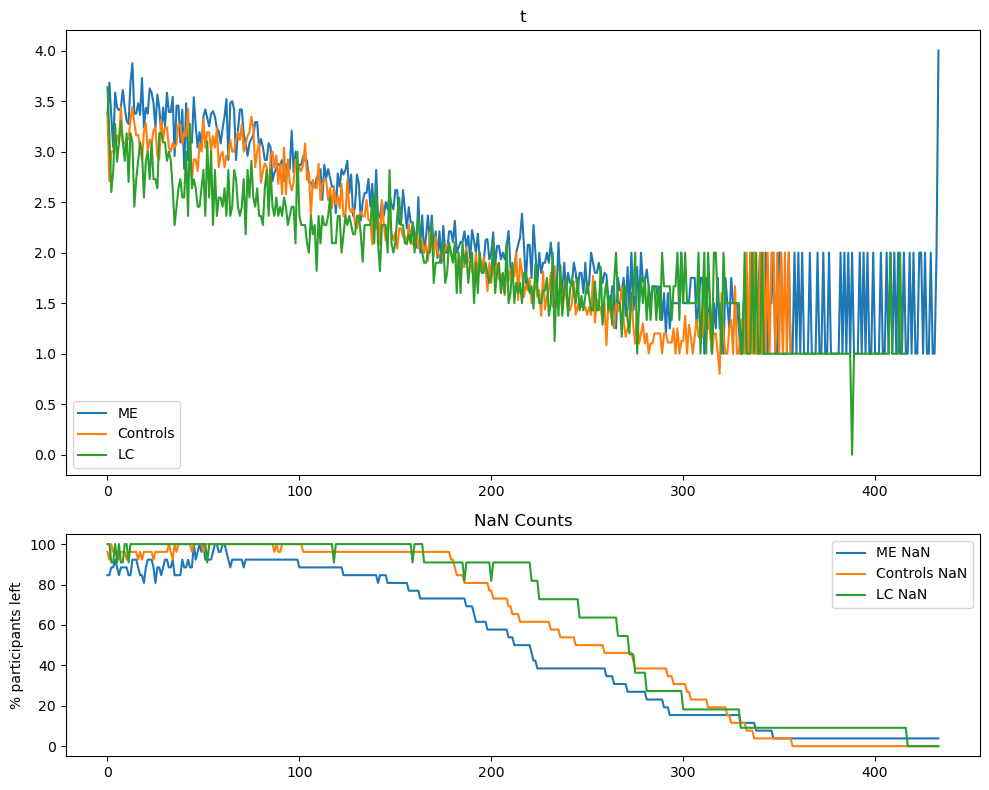

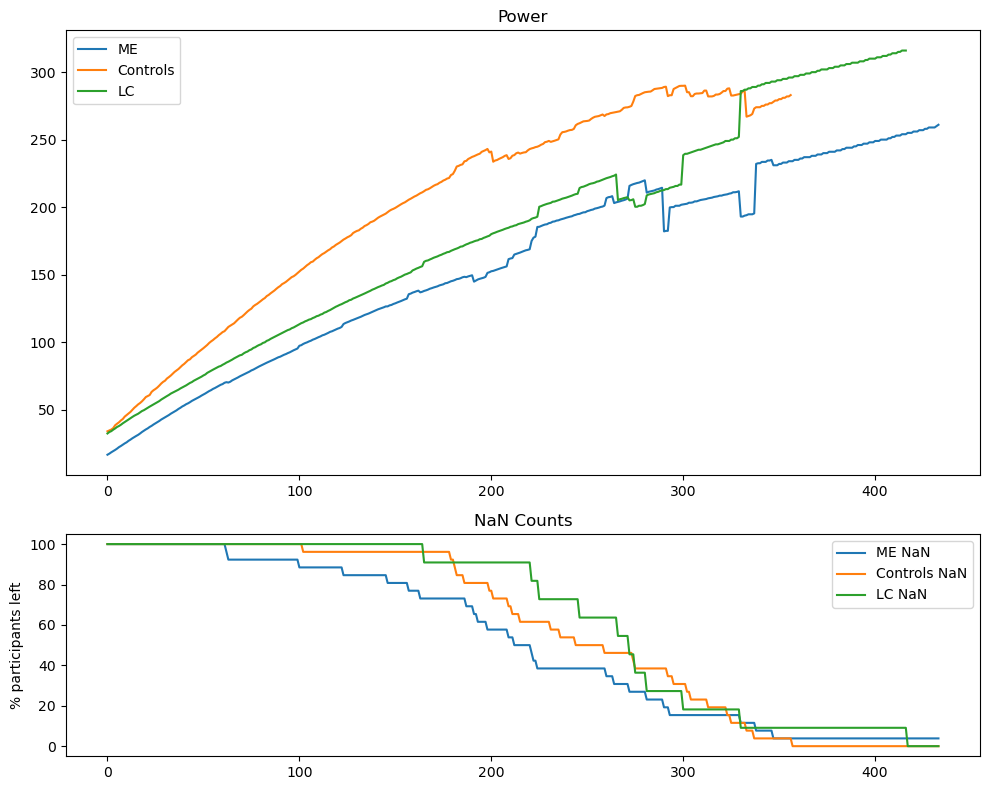

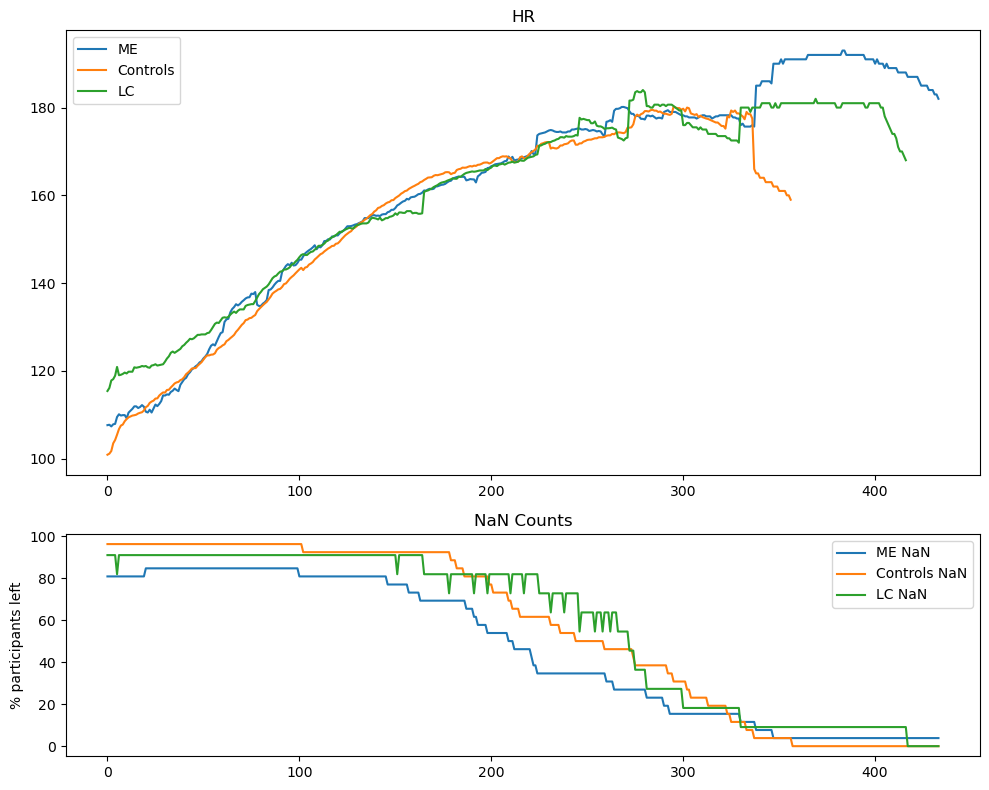

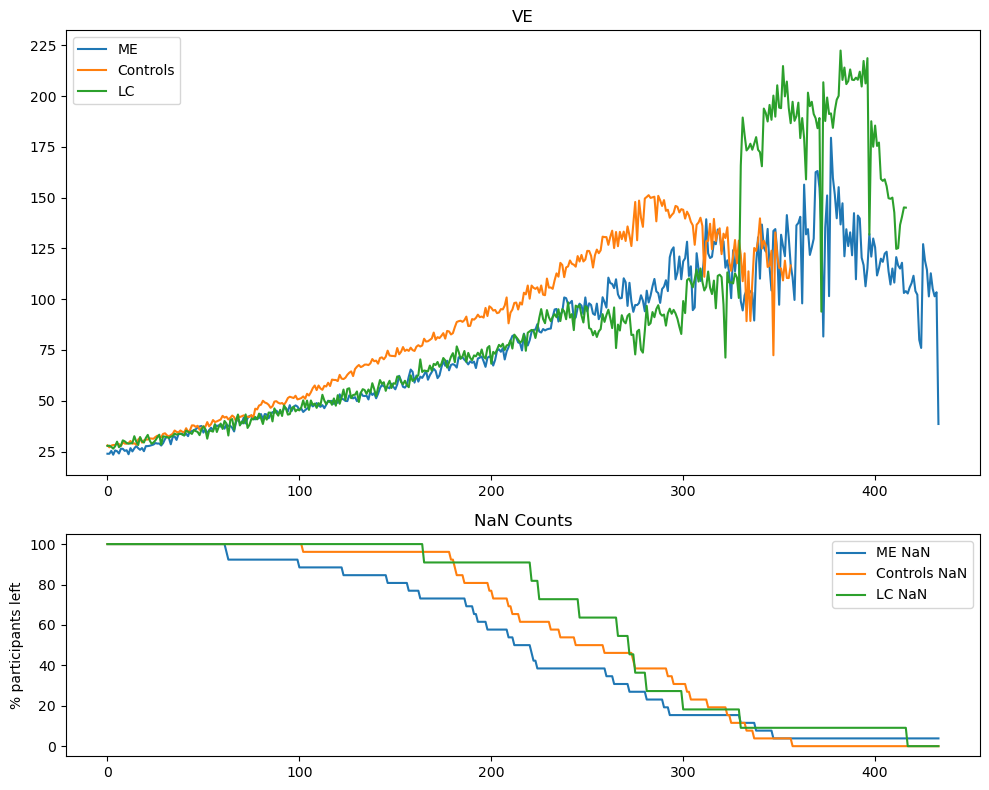

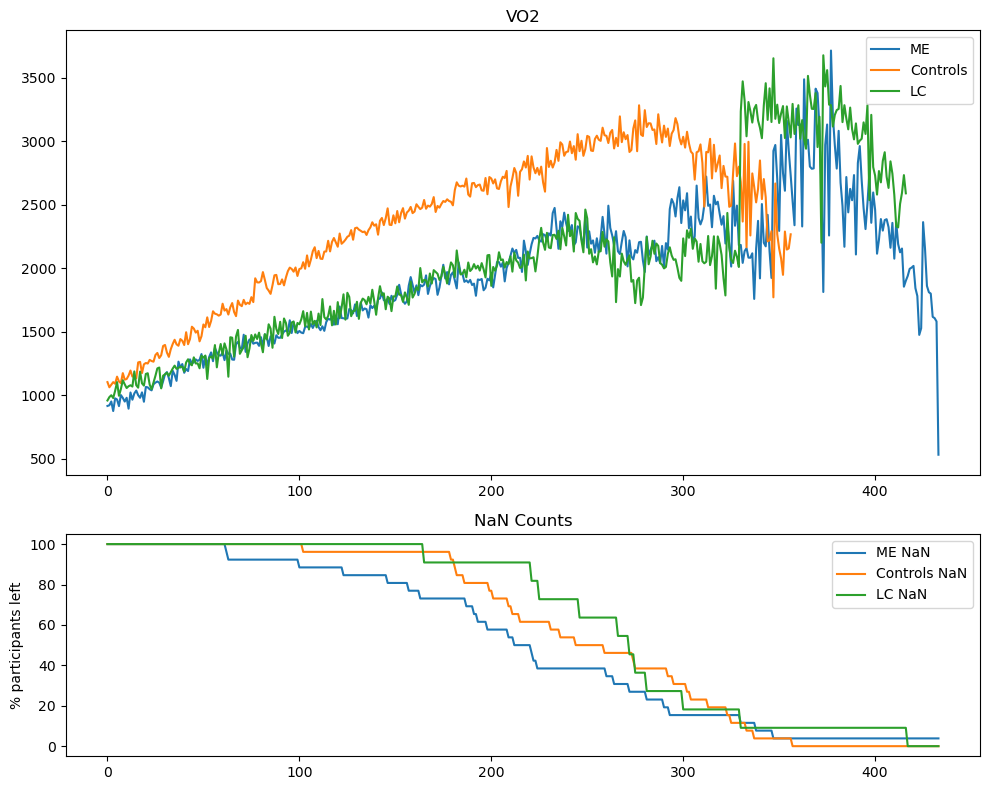

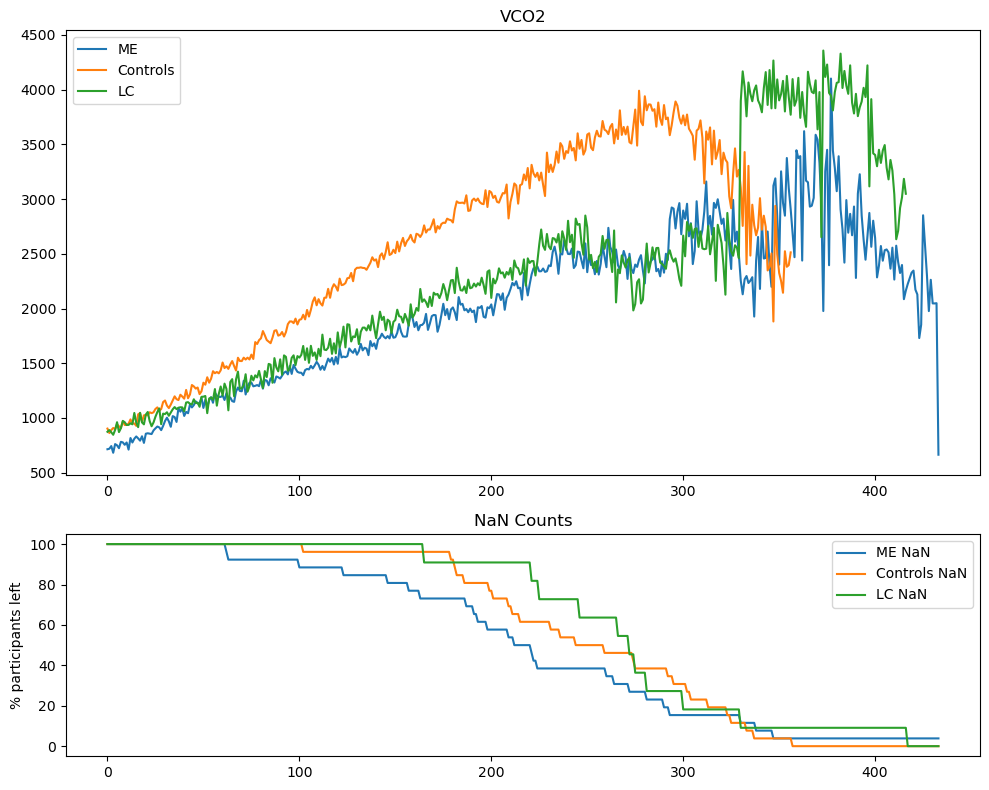

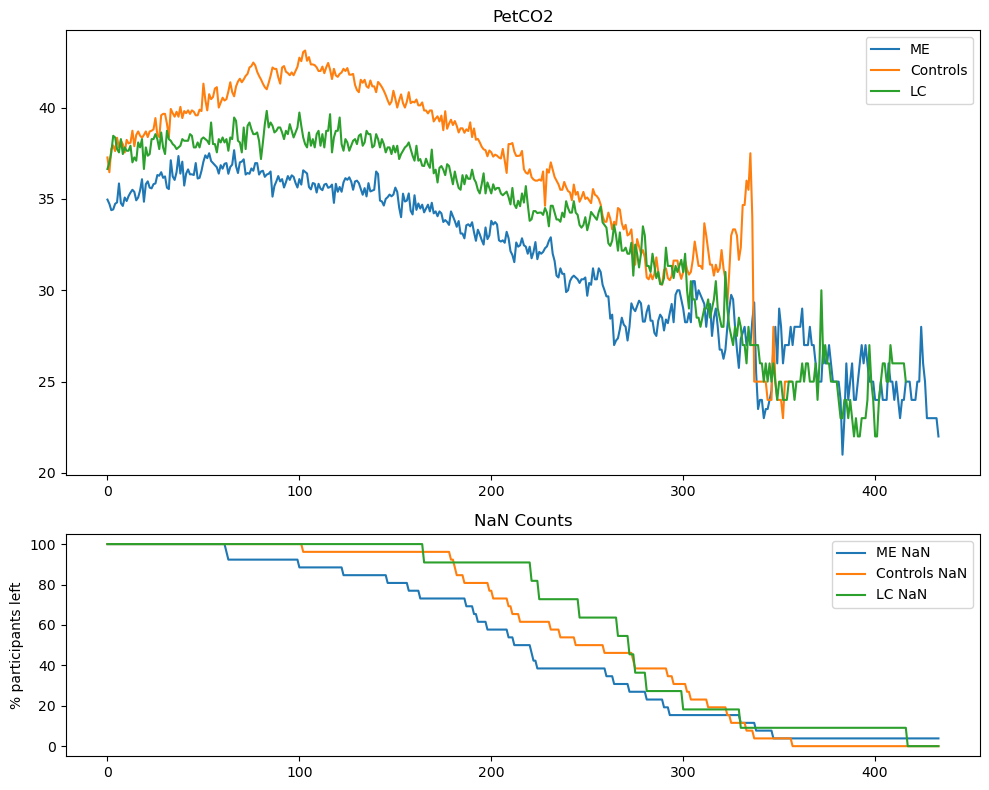

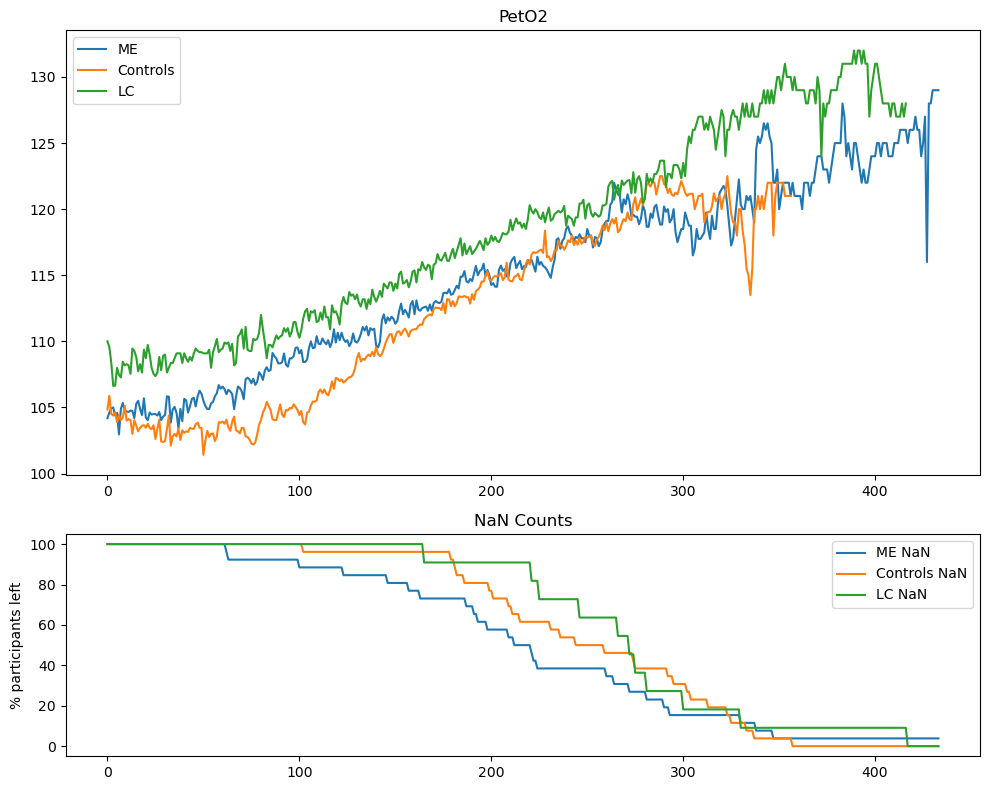

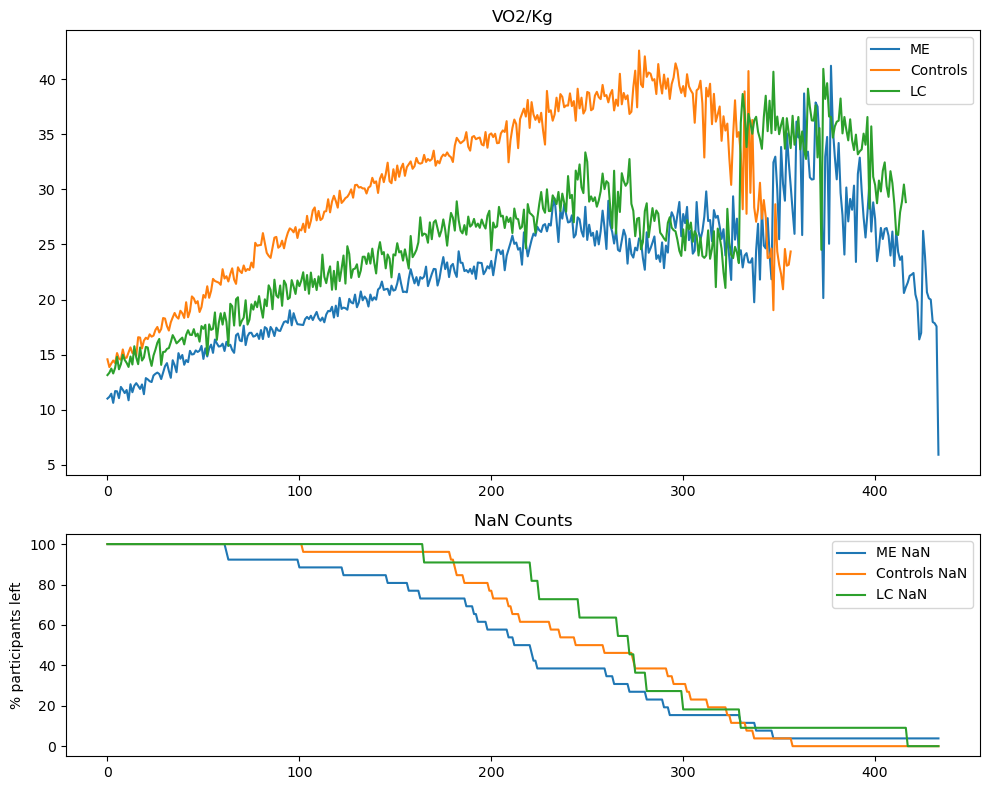

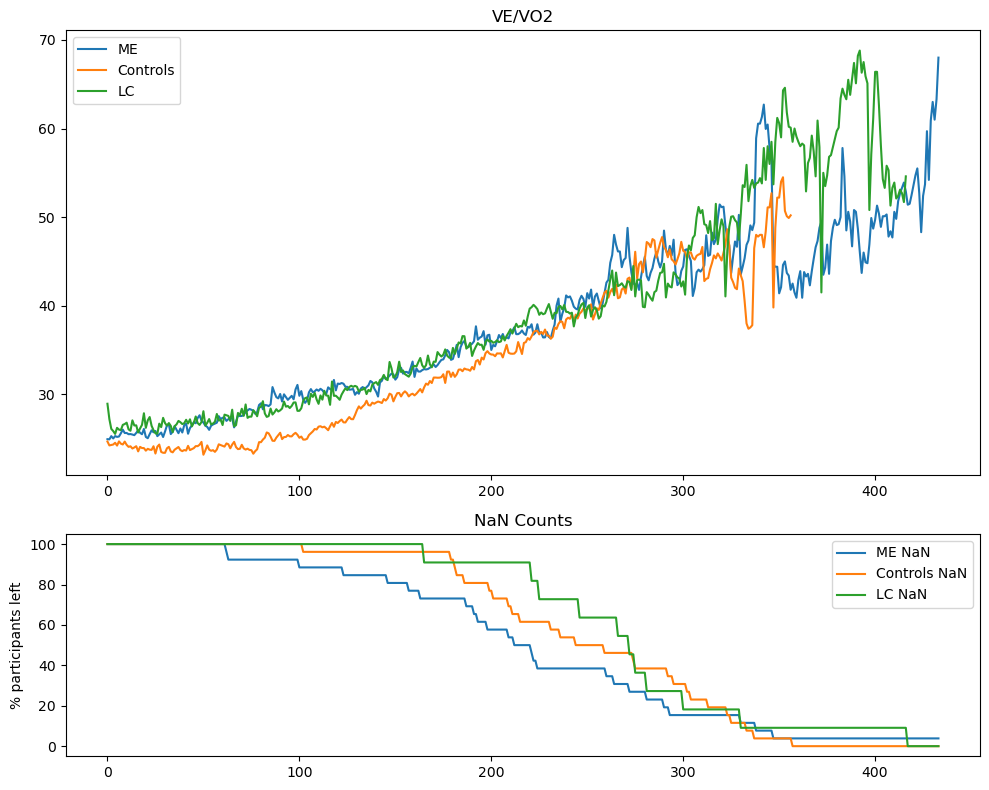

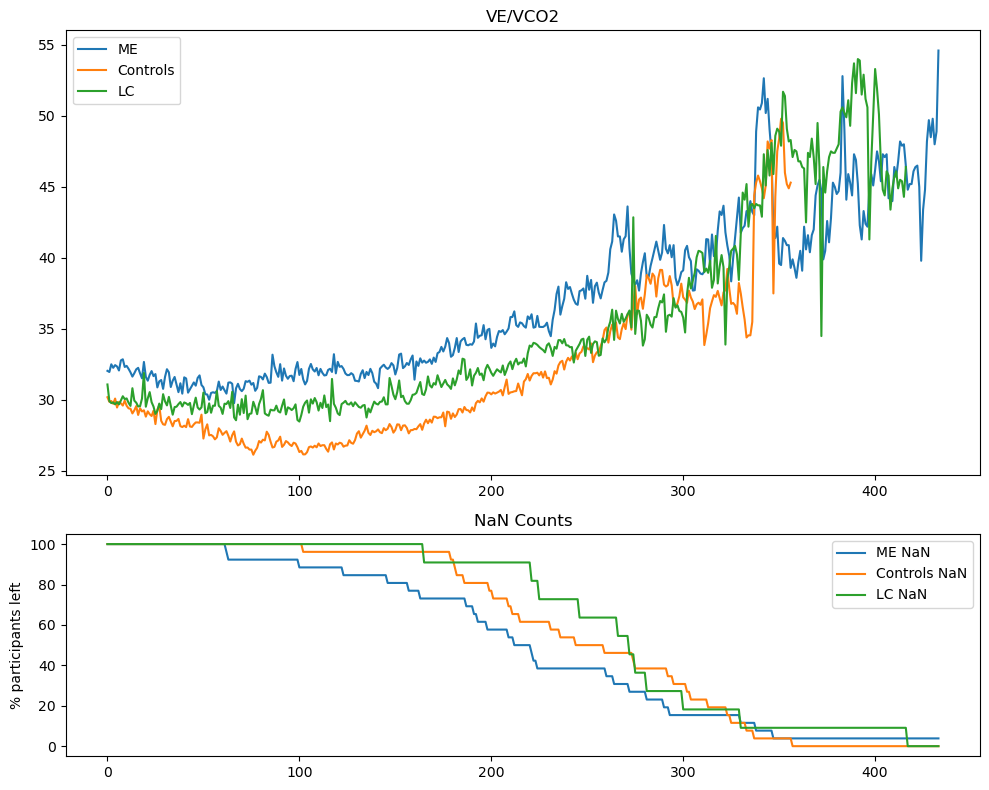

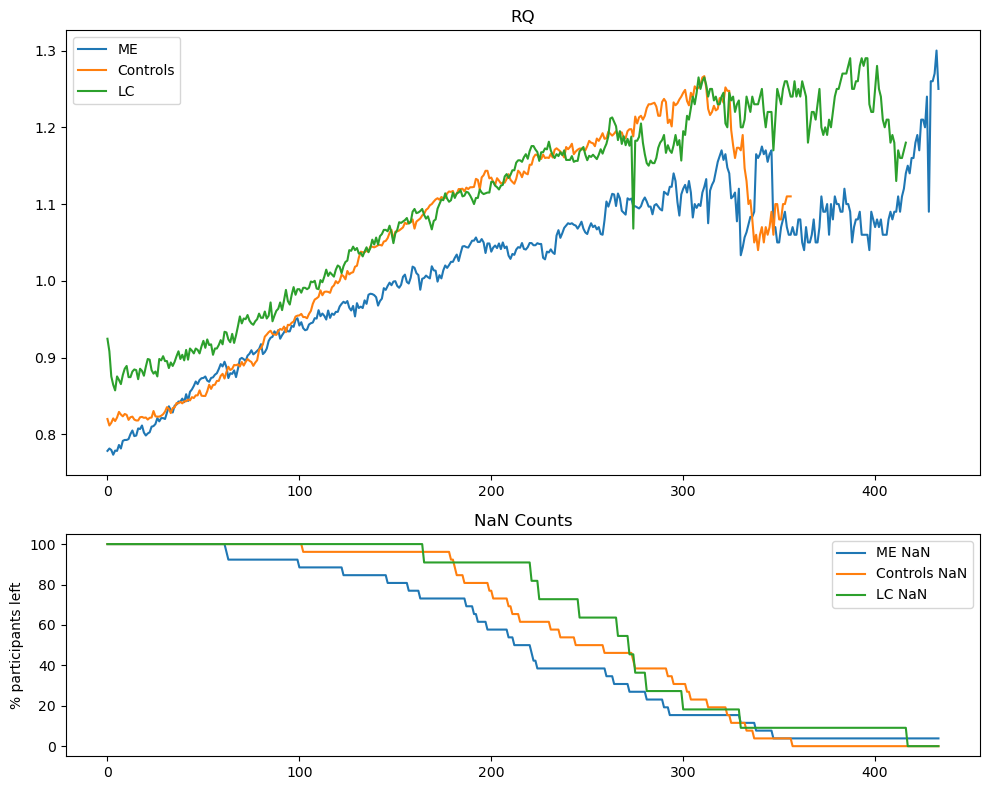

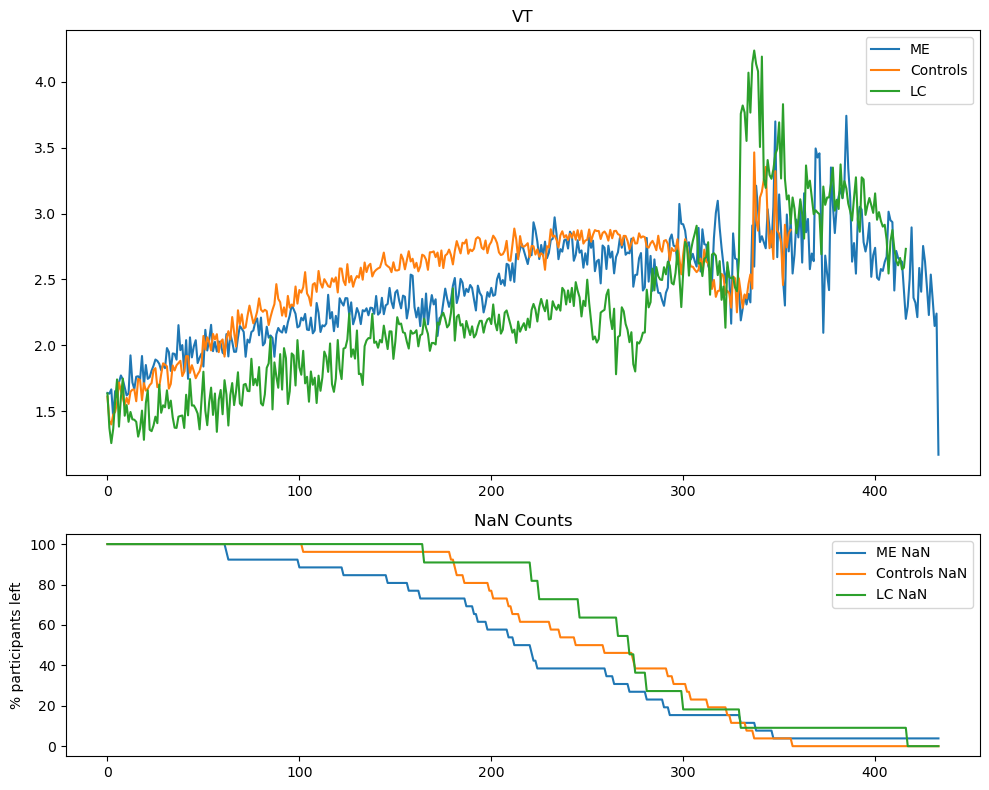

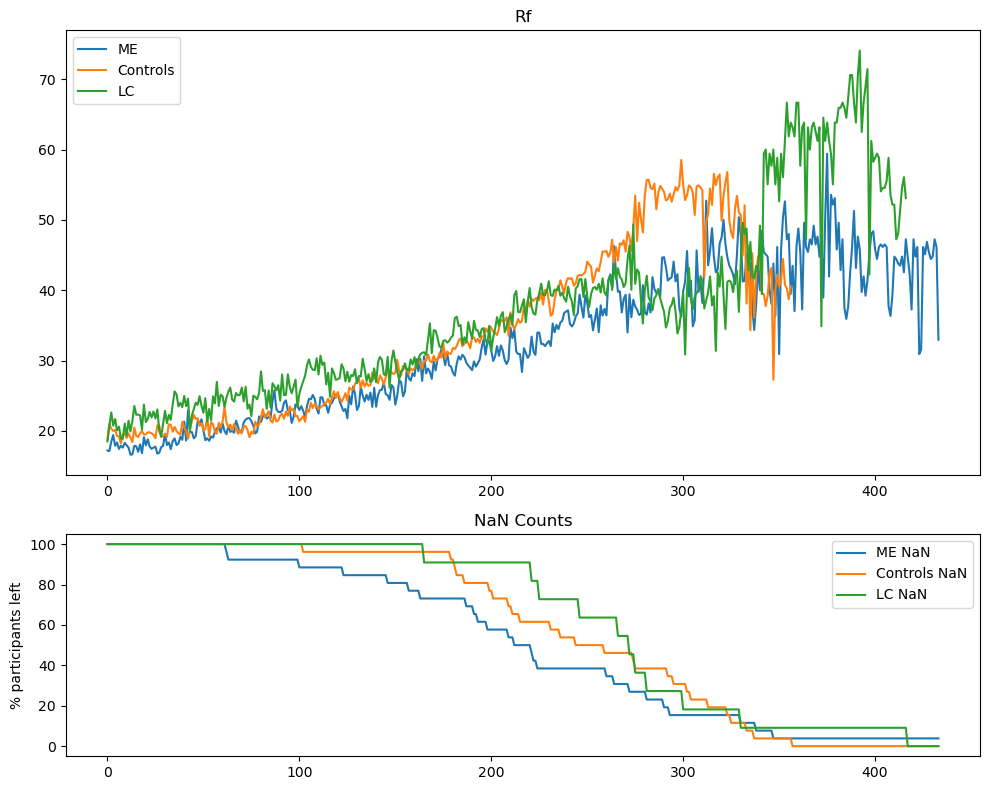

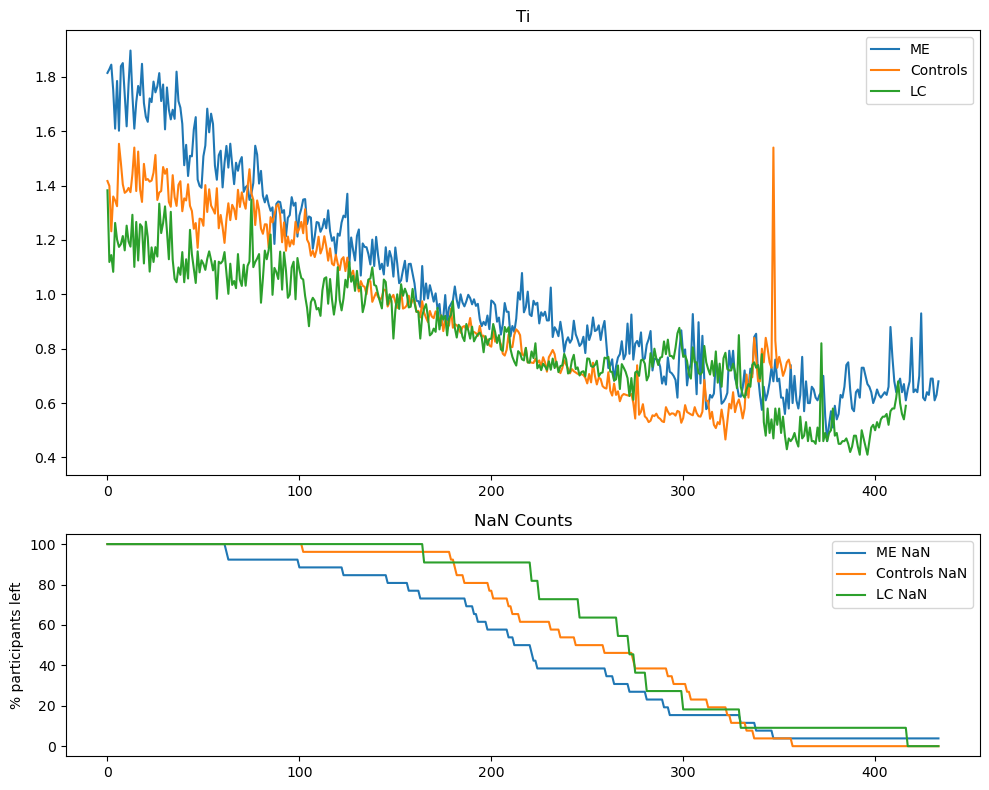

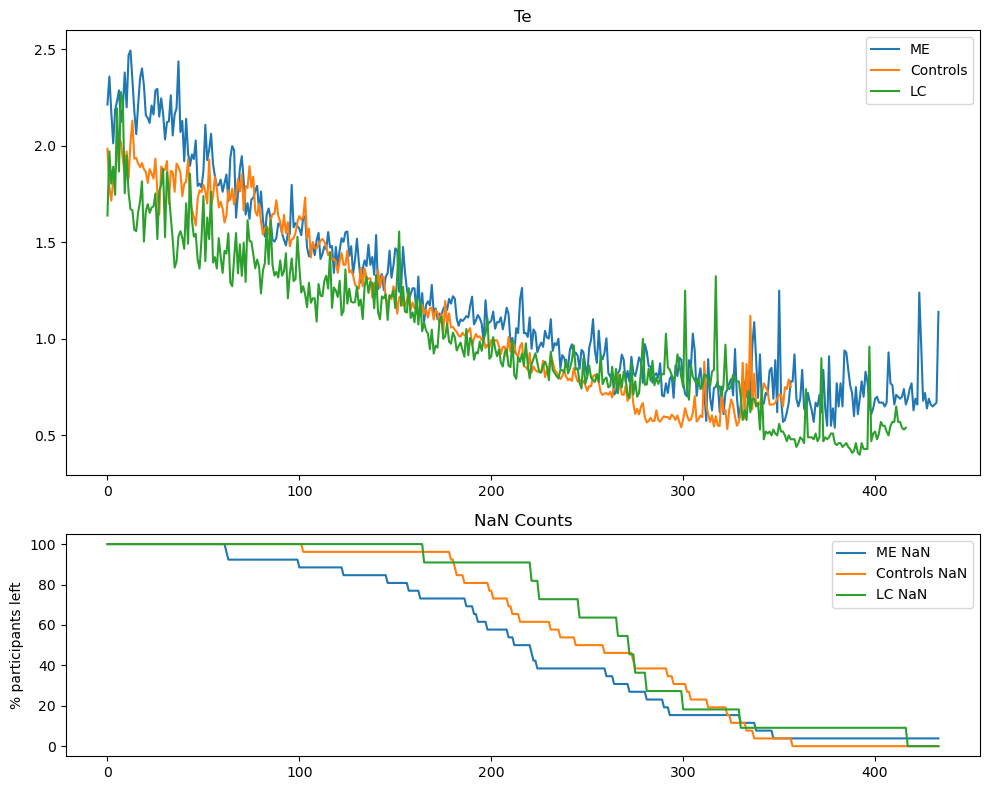

In [ ]:
for col in compnames:
    plot_group_averages(col)
